In [1]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model


import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt

Normal chest x-ray


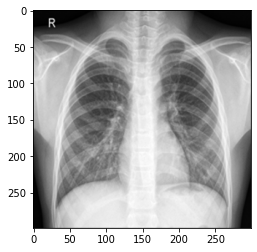

Covid chest x-ray


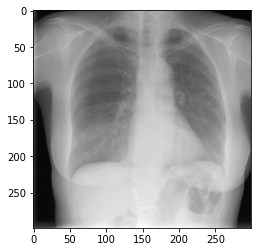

Viral Pneumonia chest x-ray


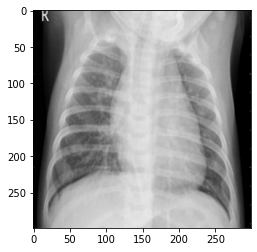

In [2]:
img_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'
covid_imgs = os.listdir(img_path+'/COVID')
normal_imgs = os.listdir(img_path+'/Normal')
pneumonia_imgs = os.listdir(img_path + '/Viral Pneumonia')

print("Normal chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Normal',normal_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

print("Covid chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'COVID',covid_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

print("Viral Pneumonia chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Viral Pneumonia',pneumonia_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

In [3]:
BATCH_SIZE = 20
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [4]:
list_files = []
for dir in os.listdir(img_path):
  aux_dir = os.path.join(img_path,dir)
  
  if os.path.isdir(aux_dir):
    for img in os.listdir(aux_dir):
      list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

,id,label
count,21165,21165
unique,21165,4
top,Lung_Opacity/Lung_Opacity-2048.png,Normal
freq,1,10192


In [5]:
def frequency_plot(df):
  freq_abs = Counter(df.label);
  freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
  total = len(df.index)
  freq_r = freq_a[0]/total
  freq_a[1] = freq_r
  freq_a.columns = ['Label','Frequência absoluta','Frequência relativa']
  return freq_a
frequency_plot(df)

,Label,Frequência absoluta,Frequência relativa
0,Normal,10192,0.481550
1,Lung_Opacity,6012,0.284054
2,Viral Pneumonia,1345,0.063548
3,COVID,3616,0.170848


In [6]:
def balance_dataset(focus_class, df):
  classes = df.label.unique()
  classes_df_list = []
  focus_class_df = df[df.label == focus_class]
  classes_df_list.append(focus_class_df)
  count_focus_class = len(focus_class_df)
  
  for classe in classes:
    class_df = df[df.label == classe]
    count_class = len(class_df)
    if classe == focus_class:
      continue
    if count_class > count_focus_class+1000:
      class_df = class_df.sample(count_focus_class+1000)
    classes_df_list.append(class_df)
  df_under = pd.concat(classes_df_list, axis=0) 
  return df_under


df = balance_dataset('COVID',df)

frequency_plot(df)

,Label,Frequência absoluta,Frequência relativa
0,COVID,3616,0.254773
1,Normal,4616,0.325231
2,Lung_Opacity,4616,0.325231
3,Viral Pneumonia,1345,0.094765


In [8]:
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['label']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['label'][train_index], df['label'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf


traindf,testdf = split_dataset(df,test_size = 0.25)
valdf,testdf= split_dataset(testdf,test_size = 0.50)



traindf.id = img_path + traindf.id
valdf.id = img_path + valdf.id
testdf.id = img_path + testdf.id

In [9]:
frequency_plot(traindf)

,Label,Frequência absoluta,Frequência relativa
0,COVID,2712,0.254791
1,Lung_Opacity,3462,0.325254
2,Viral Pneumonia,1008,0.094701
3,Normal,3462,0.325254


In [10]:
frequency_plot(valdf)

,Label,Frequência absoluta,Frequência relativa
0,COVID,452,0.254791
1,Lung_Opacity,577,0.325254
2,Viral Pneumonia,168,0.094701
3,Normal,577,0.325254


In [11]:
frequency_plot(testdf)

,Label,Frequência absoluta,Frequência relativa
0,Normal,577,0.325070
1,Lung_Opacity,577,0.325070
2,COVID,452,0.254648
3,Viral Pneumonia,169,0.095211


In [12]:
BATCH_SIZE = 20
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [13]:
BATCH_SIZE=50

"""
train_datagen = ImageDataGenerator(          
    rotation_range = 40,
    width_shift_range = 0.2,
  height_shift_range=0.2,
  shear_range = 0.2,
  zoom_range = 0.1,
  fill_mode = 'nearest',
)
"""
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


print("Creating train generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)


val_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    color_mode="rgb",
    seed=5,
    shuffle = False,
    batch_size=30,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

print("\nCreating val generator...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=5,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Creating train generator...
Found 10644 validated image filenames belonging to 4 classes.
Found 1775 validated image filenames belonging to 4 classes.

Creating val generator...
Found 1774 validated image filenames belonging to 4 classes.


In [14]:
from keras.applications.vgg16 import VGG16
base_convnet = VGG16(include_top=False, input_shape=input_shape,
                     weights='imagenet')


base_convnet.trainable = False
base_convnet.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [15]:
model = models.Sequential()
model.add(base_convnet)

"""
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3,padding='same',activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3,padding='same',activation='relu'))
model.add(layers.Dropout(0.30))
"""

# model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(4, activation='softmax',name="fc_out"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
fc_out (Dense)               (None, 4)                 4

In [16]:
checkpoints_path = '/kaggle/output/models_checkpoints/covid_project'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [17]:
EPOCHS = 50
LEARNING_RATE = 1e-5
DECAY= LEARNING_RATE/EPOCHS
model.compile(
    loss='categorical_crossentropy',
   
     optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE),
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)

callbacks = [model_checkpoint_callback,early,mcp_save]
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
50/50 [==============================] - 330s 6s/step - loss: 1.3198 - recall: 0.1352 - precision: 0.4932 - acc: 0.3860 - val_loss: 0.9073 - val_recall: 0.3680 - val_precision: 0.8000 - val_acc: 0.6400
Epoch 2/50
50/50 [==============================] - 296s 6s/step - loss: 0.9801 - recall: 0.3976 - precision: 0.6976 - acc: 0.5824 - val_loss: 0.7815 - val_recall: 0.5520 - val_precision: 0.8070 - val_acc: 0.7320
Epoch 3/50
50/50 [==============================] - 296s 6s/step - loss: 0.7812 - recall: 0.5754 - precision: 0.8074 - acc: 0.7090 - val_loss: 0.6864 - val_recall: 0.6760 - val_precision: 0.8408 - val_acc: 0.7800
Epoch 4/50
50/50 [==============================] - 318s 6s/step - loss: 0.7249 - recall: 0.6395 - precision: 0.8087 - acc: 0.7395 - val_loss: 0.5328 - val_recall: 0.7560 - val_precision: 0.8873 - val_acc: 0.8280
Epoch 5/50
50/50 [==============================] - 296s 6s/step - loss: 0.6471 - recall: 0.6650 - precision: 0.8009 - acc: 0.7519 - val_loss: 0.533

In [18]:
callbacks = [model_checkpoint_callback,early,mcp_save]

In [19]:
base_convnet.trainable= True
EPOCHS = 50

history2 = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

Epoch 1/50
50/50 [==============================] - 296s 6s/step - loss: 0.2798 - recall: 0.8868 - precision: 0.9154 - acc: 0.9000 - val_loss: 0.2981 - val_recall: 0.8720 - val_precision: 0.8934 - val_acc: 0.8920
Epoch 2/50
50/50 [==============================] - 296s 6s/step - loss: 0.2763 - recall: 0.8932 - precision: 0.9216 - acc: 0.9140 - val_loss: 0.2950 - val_recall: 0.8680 - val_precision: 0.8857 - val_acc: 0.8800
Epoch 3/50
50/50 [==============================] - 296s 6s/step - loss: 0.2737 - recall: 0.8896 - precision: 0.9126 - acc: 0.9028 - val_loss: 0.2901 - val_recall: 0.8800 - val_precision: 0.9016 - val_acc: 0.9000
Epoch 4/50
50/50 [==============================] - 296s 6s/step - loss: 0.2732 - recall: 0.8964 - precision: 0.9218 - acc: 0.9092 - val_loss: 0.3044 - val_recall: 0.8800 - val_precision: 0.9016 - val_acc: 0.8960
Epoch 5/50
50/50 [==============================] - 296s 6s/step - loss: 0.2958 - recall: 0.8848 - precision: 0.9118 - acc: 0.8976 - val_loss: 0.335

In [20]:
vgg16_model = model

In [21]:
vgg16_model.evaluate(test_generator)

60/60 [==============================] - 207s 3s/step - loss: 0.3023 - recall: 0.8918 - precision: 0.8999 - acc: 0.8986


[0.3022785186767578,
 0.8918309807777405,
 0.8999431729316711,
 0.8985915780067444]

In [22]:
from sklearn.metrics import classification_report

test_pred_raw = vgg16_model.predict(test_generator)
test_labels = np.asarray(test_generator.classes)
test_pred = np.argmax(test_pred_raw, axis=1)

class_names = list(test_generator.class_indices.keys())
print(classification_report(test_labels, test_pred))
print(test_generator.class_indices)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       452
           1       0.92      0.86      0.89       577
           2       0.87      0.94      0.90       577
           3       0.98      0.98      0.98       169

    accuracy                           0.92      1775
   macro avg       0.93      0.93      0.93      1775
weighted avg       0.92      0.92      0.92      1775

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
